## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow 
import keras

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
output_notebook()


%matplotlib inline

Loading BokehJS ...

In [59]:
# Load the data
data = pd.read_csv('../data/train.csv')
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)


def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [61]:
#Remove unnecessary variables
#del data['AnimalID']
#del data['Name']
#del data['DateTime']
#del data['Breed']
#del data['OutcomeSubtype']
#del data['SexuponOutcome']
#del data['AgeuponOutcome']
#del data['Color']
#del data['OrderedBreed']
#del data['OrderedColor']

continuous = ['ConvertedAge']
discrete = [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named'
]
target = 'OutcomeType'

print data.ConvertedAge.unique()

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
data[continuous].describe().T

[  5.20000000e+01   1.04000000e+02   3.00000000e+00   4.50000000e+00
   2.25000000e+01   2.08000000e+02   1.35000000e+01   2.00000000e+00
   9.00000000e+00   4.50000000e+01   2.70000000e+01   2.60000000e+02
   3.64000000e+02   1.56000000e+02   1.80000000e+01   6.24000000e+02
   4.68000000e+02   3.12000000e+02   1.00000000e+00   5.72000000e+02
   4.00000000e+00   3.15000000e+01   4.16000000e+02   4.95000000e+01
   0.00000000e+00   4.05000000e+01   3.60000000e+01   7.80000000e+02
   5.20000000e+02   7.28000000e+02   5.00000000e+00   8.32000000e+02
   6.76000000e+02   8.84000000e+02   9.36000000e+02   9.88000000e+02
   1.04000000e+03]


,count,mean,std,min,25%,50%,75%,max
ConvertedAge,26729.0,113.370253,154.064766,0.0,9.0,52.0,156.0,1040.0


In [63]:
#Turn categorical variables into binaries
data2 = pd.concat([data[target], data[continuous], pd.get_dummies(data[discrete])], axis=1)

data2.head()

,OutcomeType,ConvertedAge,AnimalType_Cat,AnimalType_Dog,Female_Female,Female_Male,Female_Unknown,Intact_Intact,Intact_Spayed/Neutered,Intact_Unknown,MixedBreed_Known Breed Combo,MixedBreed_Mixed Breed,MixedBreed_Nonmixed,Named_Named,Named_Unnamed
0,Return_to_owner,52.0,0,1,0,1,0,0,1,0,0,1,0,1,0
1,Euthanasia,52.0,1,0,1,0,0,0,1,0,0,1,0,1,0
2,Adoption,104.0,0,1,0,1,0,0,1,0,0,1,0,1,0
3,Transfer,3.0,1,0,0,1,0,1,0,0,0,1,0,0,1
4,Transfer,104.0,0,1,0,1,0,0,1,0,1,0,0,0,1


In [64]:
discrete = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed']

predictors = continuous + discrete

# Train/test split
X = data2[predictors]
y = data2[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

#Normalize 
ss = StandardScaler()
ss.fit(X_train[continuous])   # Compute mean and std of training data
X_train[continuous] = ss.transform(X_train[continuous])  # Use that mean and std to normalize columns of training data
X_dev[continuous] = ss.transform(X_dev[continuous]) 

/Users/yubozhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yubozhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Visualizing Features

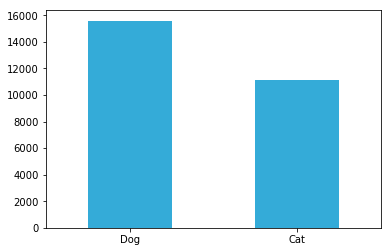

In [74]:
#A quick look at the variables

#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [75]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

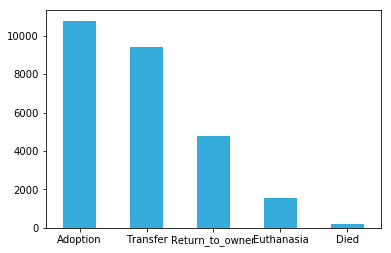

In [76]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

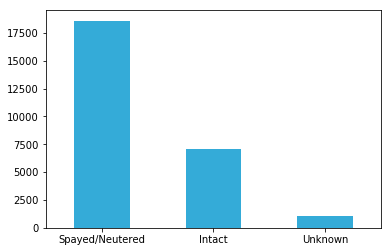

In [77]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [78]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

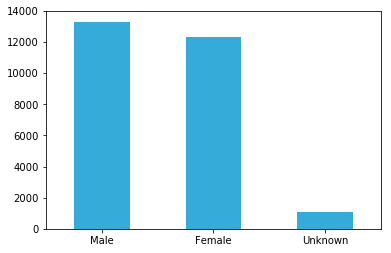

In [79]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [80]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

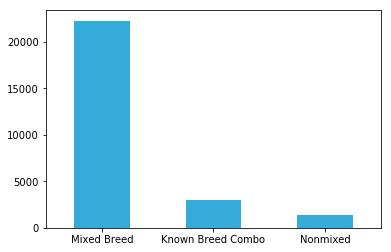

In [81]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [82]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12456e990>]], dtype=object)

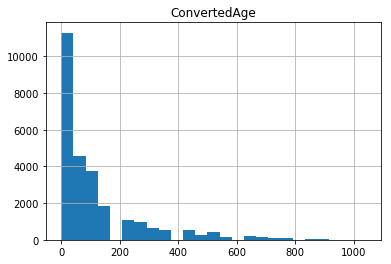

In [83]:
data.hist(column="ConvertedAge", bins=25)

In [84]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

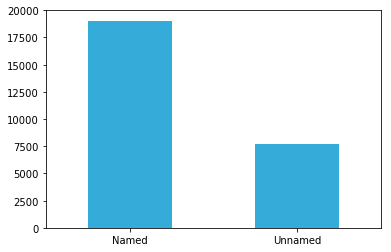

In [85]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [86]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [87]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

('Unique Colors', 275)
['Brown White' 'Cream-Tabby' 'Blue White' 'Blue-Cream' 'Tan' 'Black Tan'
 'Blue-Tabby' 'Brown-Tabby' 'Red White' 'White' 'Black' 'Silver' 'Brown'
 'Black Red' 'Cream White' 'Orange-Tabby White' 'Black White'
 'Brown-Brindle White' 'Black Brown' 'Orange-Tabby' 'Chocolate White'
 'Tan White' 'Cream-Tabby White' 'Blue' 'Calico' 'Torbie' 'Yellow'
 'Tricolor' 'Tortie' 'Blue-Tabby White' 'Gray White' 'Buff'
 'Brown-Tabby White' 'Red' 'Blue Tan' 'Seal-Point' 'Brown-Brindle' 'Gray'
 'White Yellow-Brindle' 'Fawn White' 'Flame-Point' 'Black-Tabby White'
 'Calico Tortie' 'Black Brown-Brindle' 'Silver Tan' 'Black Red-Tick'
 'Blue-Merle' 'Chocolate Tan' 'Sable' 'Brown-Merle White'
 'Brown-Tiger White' 'Liver White' 'Black Gray' 'Cream' 'Chocolate'
 'Blue-Point' 'Apricot White' 'Black Red-Merle' 'Blue-Merle White' 'Fawn'
 'Lynx-Point White' 'Black Fawn' 'Red-Tick White' 'Buff Tan'
 'Brown-Brindle Red-Tick' 'Lilac-Point' 'Buff White' 'Tortie-Point'
 'Lynx-Point' 'Tortie White' 

In [88]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

('Unique Breeds', 1143)
['Shetland-Sheepdog-Mix' 'Domestic-Shorthair-Mix' 'Pit-Bull-Mix' ...,
 'English-Bulldog French-Bulldog' 'Boxer Vizsla'
 'Australian-Kelpie German-Shepherd']


In [89]:
def main():
    print "Number of observations: ", len(data.index)
    print "Number of columns: ", len(data.columns)
    print "Headers: ", data.columns.values

if __name__ == "__main__":
    main()



Number of observations:  26729
Number of columns:  17
Headers:  ['AnimalID' 'Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color' 'Female' 'ConvertedAge'
 'Intact' 'MixedBreed' 'Named' 'OrderedColor' 'OrderedBreed']


### LOGISTIC REGRESSION

In [90]:
print X_train.shape
print y_train.shape
print X_dev.shape
print y_dev.shape

#y_train = y_train.values.ravel()
y_dev = y_dev.values.ravel()

(20046, 14)
(20046, 1)
(6683, 14)
(6683, 1)


In [93]:
def lr_model():
    
    #Generate logistic regression
    def logit_reg(X_train, X_dev):
        logit_reg = LogisticRegression(penalty="l2", multi_class='multinomial', solver='newton-cg')  
        
        #Test C within [0.001, 10]
        param_domain = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]
        param_dict = dict(C = param_domain)

        #Initialize GridSearchCV to identify the optimal parameter values
        gridsearch = GridSearchCV(logit_reg, param_dict)
        gridsearch.fit(X_train, y_train)
        
        #Generate model at the best C value
        C = gridsearch.best_params_["C"]
        print "Train data: Logistic Regression score at C=%.3f: %f" % (C, gridsearch.best_score_)
        print ('\n' * 1)
        logit_reg = LogisticRegression(C=C, penalty="l2")
        logit_reg.fit(X_train, y_train)

        #Predict on the X_dev set
        logit_reg_dev = logit_reg.predict(X_dev)

        #Generate classification report
        print "Classification Report:"
        print " "
        print classification_report(y_dev, logit_reg_dev, target_names=y_dev)
        print "Dev data: Logistic Regression score at C=%.3f: %f" % (C, metrics.f1_score(y_dev, logit_reg_dev, average="weighted"))    
        print ('\n' * 2)

        
        #Generate logistic regression and add the squared weight values to an array, at each C
        logit_reg_coeff = []
        for c in param_domain:
            logit_reg = LogisticRegression(C=c, penalty="l2") 
            logit_reg.fit(X_train, y_train)
            squared_weights = []
            squared_weights.append(c)                       
            for i in range(0, 4):
                [squared_weights.append(np.sum(np.power(logit_reg.coef_[i], 2)))]
            logit_reg_coeff.append(squared_weights)
            
        coeff = np.asarray(logit_reg_coeff, dtype = "object")
        
    
    logit_reg(X_train, X_dev)
    
lr_model()    

IndexError: too many indices for array

### Neural Network 

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelBinarizer

In [55]:
# hot encoding to transform training and development data
lb_style = LabelBinarizer()
y_train_hot = lb_style.fit_transform(y_train)
y_train_hot
y_dev_hot = lb_style.fit_transform(y_dev)

In [56]:
# using keras to predict the accuracy
model = Sequential([
    Dense(32, input_shape=(14,)),
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(np.array(X_train), y_train_hot, epochs=10, batch_size=32)

Epoch 1/10
20046/20046 [==============================] - 2s - loss: 0.3631 - acc: 0.8338     
Epoch 2/10
20046/20046 [==============================] - 1s - loss: 0.3223 - acc: 0.8582     
Epoch 3/10
20046/20046 [==============================] - 1s - loss: 0.3163 - acc: 0.8592     
Epoch 4/10
20046/20046 [==============================] - 1s - loss: 0.3144 - acc: 0.8598     
Epoch 5/10
20046/20046 [==============================] - 1s - loss: 0.3133 - acc: 0.8598     
Epoch 6/10
20046/20046 [==============================] - 1s - loss: 0.3120 - acc: 0.8601     
Epoch 7/10
20046/20046 [==============================] - 1s - loss: 0.3110 - acc: 0.8606     
Epoch 8/10
20046/20046 [==============================] - 1s - loss: 0.3099 - acc: 0.8611     
Epoch 9/10
20046/20046 [==============================] - 1s - loss: 0.3088 - acc: 0.8612     
Epoch 10/10
20046/20046 [==============================] - 1s - loss: 0.3079 - acc: 0.8614     


In [57]:
score = model.evaluate(np.array(X_dev), y_dev_hot, batch_size=16)

print '\nAccurancy on test data', score[1]

6400/6683 [===========================>..] - ETA: 0s
Accurancy on test data 0.861469394706
